# Bayesian neural networks




In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '5'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [5]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


import sys

import flax
from flax import linen as nn

import bamojax
from bamojax.base import Model
from bamojax.inference import SGMCMCInference, SMCInference, MCMCInference
from bamojax.samplers import gibbs_sampler, mcmc_sampler

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Flax version:         ', flax.__version__)
print('Distrax version:      ', dx.__version__)
print('Bamojax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Flax version:          0.10.0
Distrax version:       0.1.5
Bamojax version:       0.0.2+2.g8e56fa1.dirty
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


Code works for:

- Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
- Jax version:           0.4.35
- BlackJax version:      1.2.4
- Flax version:          0.10.0
- Distrax version:       0.1.5
- BaMoJax version:       0.0.2

Note that depending on the MLP size, SMC is of course not the best option due to its memory requirements. Set `return_diagnostics=False` to reduce memory consumption by a lot, but for realistic BNN applications, use a stochastic gradient MCMC method instead.

## The basic MLP

First, some plotting functions:

In [58]:
def plot_double_moon_fit(xgrid, samples, data, levels=20, title=None):
    X, Y = data
    xv, yv = xgrid
    data_colors = ["tab:red" if yn==1 else "tab:blue" for yn in Y]    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))
    
    mu = jnp.mean(samples, axis=0)
    sigma = jnp.std(samples, axis=0)
    axes[0].contourf(xv, yv, mu, zorder=0, cmap="twilight", vmin=0.0, vmax=1.0, levels=levels)
    axes[1].contourf(xv, yv, sigma, zorder=0, cmap="inferno_r", vmin=0.0, vmax=0.4, levels=levels)

    axes[0].set_title('Expectation')
    axes[1].set_title('Uncertainty')

    for ax in axes.flatten():
        ax.scatter(*X.T, c=data_colors, zorder=2, linewidths=0.5, edgecolors='k')
        ax.set_xticks([])
        ax.set_yticks([])

    if title is not None:
        fig.suptitle(title)

#

Then the actual MLP:

In [4]:
class MLP(nn.Module):

    layer_widths: list[int]

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths:
            x = nn.Dense(features=width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)
    
    #    

#

Simulate observations:

In [5]:
from sklearn.datasets import make_moons

noise = 0.2
num_obs = 200

X, Y = make_moons(noise=noise, n_samples=num_obs)
n, p = X.shape

widths = [50, 40, 40]
network = MLP(layer_widths=widths)

def get_num_weights(widths, p):
    sizes = widths.copy()
    sizes.insert(0, p)
    sizes.append(1)

    m = 0
    for w in range(len(sizes) - 1):
        m += (sizes[w]+1) * sizes[w+1]
    return m

#
_, mlp_unravel_fn = jax.flatten_util.ravel_pytree(network.init(jrnd.PRNGKey(0), jnp.ones(p)))

num_weights = get_num_weights(widths, p)
print('Total number of weights in MLP:', num_weights)

Total number of weights in MLP: 3871


Here, the link function is just the application of the network. The key step is to unravel the weight vector into the NN architecture. 

In [18]:
def mlp_link_fn(w, X):  
    if jnp.ndim(X) == 1:
        X = X[:, None]

    w_ = mlp_unravel_fn(w)
    fpreds = network.apply(w_, X).squeeze()
    return dict(probs=jax.nn.sigmoid(fpreds))
    
#

Set up SMC inference. The Gibbs kernel doesn't add much here - there is only one latent variable, $w$, but this allows for easy extensions. 

In [ ]:
%%time

key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)
BNN = Model('Bayesian neural network')
weights = BNN.add_node('w', distribution=dx.Normal, parents=dict(loc=0.0, scale=0.5), shape=(num_weights,))
x_node = BNN.add_node('X', observations=X)
y_node = BNN.add_node('Y', distribution=dx.Bernoulli, parents=dict(w=weights, X=x_node), link_fn=mlp_link_fn, observations=Y)

step_fns = dict(w=blackjax.normal_random_walk)
step_fn_params = dict(w=dict(sigma=0.01*jnp.eye(num_weights)))

gibbs = gibbs_sampler(BNN, step_fns=step_fns, step_fn_params=step_fn_params)
engine = SMCInference(model=BNN, num_particles=num_1000particles, num_mutations=50, mcmc_kernel=gibbs, return_diagnostics=False)

result_gaussian = engine.run(subkey)

print('log marginal likelihood:', result_gaussian['lml'])

log marginal likelihood: -47.065676145078754
CPU times: user 2min 54s, sys: 1min 14s, total: 4min 8s
Wall time: 4min 7s


## Visualize result

We can visualize the posterior predictive, that is, $p(y^* \mid \mathbf{X}, \mathbf{Y}, x^*)$:

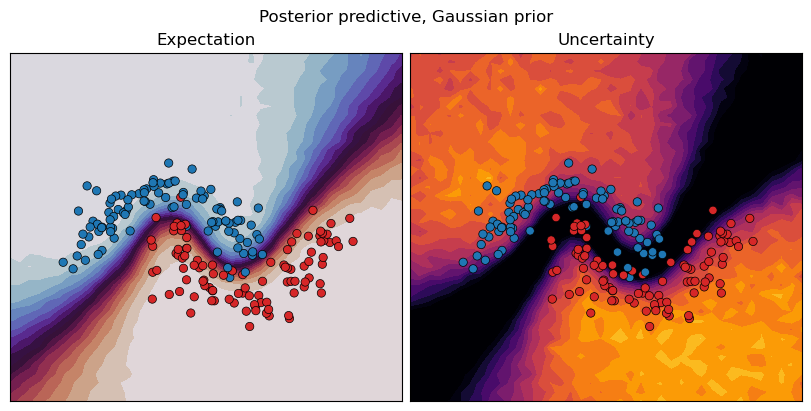

In [46]:
# Make prediction grid x*
num_x, num_y = 40, 40
xv, yv = jnp.meshgrid(jnp.linspace(-2.0, 3.0, num=num_x), jnp.linspace(-2.0, 3.0, num=num_y))
xpred = jnp.vstack([xv.flatten(), yv.flatten()]).T

keys = jrnd.split(jrnd.PRNGKey(0), num_particles)
predictions = jax.vmap(BNN.sample_posterior_predictive, in_axes=(0, 0, None))(keys, result_gaussian['final_state'].particles, dict(X=xpred))
plot_double_moon_fit(xgrid=(xv, yv), samples=predictions['Y'].reshape((num_particles, num_x, num_y)), data=(X, Y), title='Posterior predictive, Gaussian prior')

The shapes of the expectation and the uncertainty nicely follow the data distribution. 

Now we set up a Laplace prior on the weights instead, promoting small weights. Note that other than this prior, there is no structure and all weights are treated as iid.

In [ ]:
%%time

key = jrnd.PRNGKey(1337)
key, subkey = jrnd.split(key)
BNN_Laplace = Model('Bayesian neural network - Laplace prior')
weights = BNN_Laplace.add_node('w', distribution=dx.Laplace, parents=dict(loc=0.0, scale=0.5), shape=(num_weights,))
x_node = BNN_Laplace.add_node('X', observations=X)
y_node = BNN_Laplace.add_node('Y', distribution=dx.Bernoulli, parents=dict(w=weights, X=x_node), link_fn=mlp_link_fn, observations=Y)

step_fns = dict(w=blackjax.normal_random_walk)
step_fn_params = dict(w=dict(sigma=0.01*jnp.eye(num_weights)))

gibbs = gibbs_sampler(BNN_Laplace, step_fns=step_fns, step_fn_params=step_fn_params)
engine = SMCInference(model=BNN_Laplace, num_particles=1000, num_mutations=50, mcmc_kernel=gibbs, return_diagnostics=True)

result_laplace = engine.run(subkey)

print(f'Acceptance rate w:', jnp.mean(result_laplace['final_info'].update_info['w'].is_accepted))
print('log marginal likelihood, Laplace prior: ', result_laplace['lml'])

Acceptance rate w: 0.43287998
log marginal likelihood, Laplace prior:  -39.35312707276428
CPU times: user 2min 24s, sys: 3.09 s, total: 2min 27s
Wall time: 2min 31s


Visualize the posterior predicitve again:

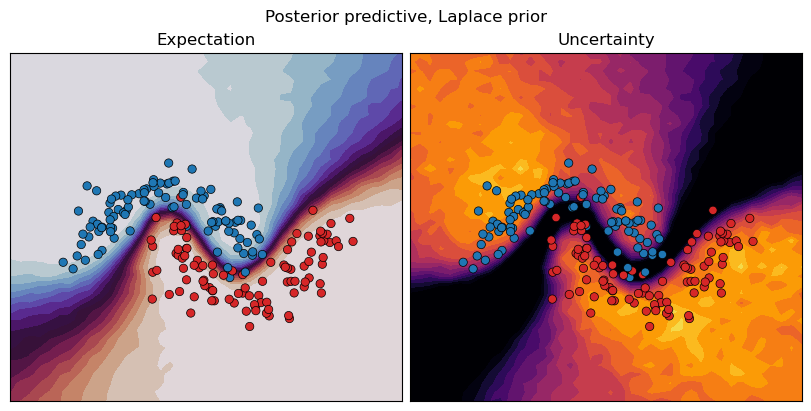

In [41]:
keys = jrnd.split(jrnd.PRNGKey(0), num_particles)
predictions_laplace = jax.vmap(BNN_Laplace.sample_posterior_predictive, in_axes=(0, 0, None))(keys, result_laplace['final_state'].particles, dict(X=xpred))
plot_double_moon_fit((xv, yv), predictions_laplace['Y'].reshape((num_particles, num_x, num_y)), title='Posterior predictive, Laplace prior', data=(X, Y))

# Multiclass MLP

Let's move beyond the 2D binary classification and use a BNN for image classification.

In [ ]:
from sklearn import datasets
data = datasets.load_digits()
N, res, _ = data.images.shape

X = jnp.reshape(data.images, shape=(N, -1))
y = data.target
num_classes = len(jnp.unique(y))

N, p = X.shape

print('digits dataset')
print(f'N: {N}, p: {p}, K: {num_classes}')

n_train = 1300

X_train = X[:n_train, :]
y_train = y[:n_train]
X_test = X[n_train:, :]
y_test = y[n_train:]

digits dataset
N: 1797, p: 64, K: 10


Construct MLP:

In [ ]:
class MultiClassMLP(nn.Module):

    layer_widths: list[int]

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths:
            x = nn.Dense(features=width)(x)
            x = nn.tanh(x)  
        return jax.nn.softmax(x)
    
    #    

#
widths = [32, num_classes]
network = MultiClassMLP(layer_widths=widths)

def get_num_weights(network, p):
    return jax.tree.reduce(lambda x, y: x+y, jax.tree.map(lambda x: jnp.size(x), network.init(jrnd.PRNGKey(0), jnp.ones(p))['params']))

#
_, mlp_unravel_fn = jax.flatten_util.ravel_pytree(network.init(jrnd.PRNGKey(0), jnp.ones(p)))

num_weights = get_num_weights(network, p)
print('Total number of weights in BMC MLP:', num_weights)

params = network.init(jrnd.PRNGKey(0), jnp.ones(p))

for layer_params in params['params'].items():
    weights, biases = layer_params[1]['kernel'], layer_params[1]['bias']
    print(f'Layer size: {weights.shape}, biases: {biases.shape}')

Total number of weights in BMC MLP: 2410
Layer size: (64, 32), biases: (32,)
Layer size: (32, 10), biases: (10,)


Construct BNN:

In [6]:
def mc_mlp_link_fn(w, X):  
    if jnp.ndim(X) == 1:
        X = X[:, None]

    w_ = mlp_unravel_fn(w)
    fpreds = network.apply(w_, X).squeeze()
    return dict(probs=fpreds)
    
#

BMCMLP = Model('Bayesian multiclass MLP')
weights = BMCMLP.add_node('w', distribution=dx.Normal, parents=dict(loc=0.0, scale=0.5), shape=(num_weights, ))
x_node = BMCMLP.add_node('X', observations=X)
y_node = BMCMLP.add_node('y', distribution=dx.Categorical, parents=dict(w=weights, X=x_node), link_fn=mc_mlp_link_fn, observations=y)

Run inference:

In [10]:
%%time

step_fns = dict(w=blackjax.normal_random_walk)
step_fn_params = dict(w=dict(sigma=0.01*jnp.eye(num_weights)))

gibbs = gibbs_sampler(BMCMLP, step_fns=step_fns, step_fn_params=step_fn_params)
engine = SMCInference(model=BMCMLP, num_particles=num_particles, num_mutations=50, mcmc_kernel=gibbs, return_diagnostics=False)
result = engine.run(key=jrnd.PRNGKey(0))

CPU times: user 5min 45s, sys: 8.63 s, total: 5min 54s
Wall time: 5min 56s


Create predictions for test set:

In [ ]:
keys = jrnd.split(jrnd.PRNGKey(0), num_particles)
predictions = jax.vmap(BMCMLP.sample_posterior_predictive, in_axes=(0, 0, None))(keys, result['final_state'].particles, dict(X=X_test))

Summarize performance by constructing the confusion matrix, using the maximum a posteriori label as our prediction:

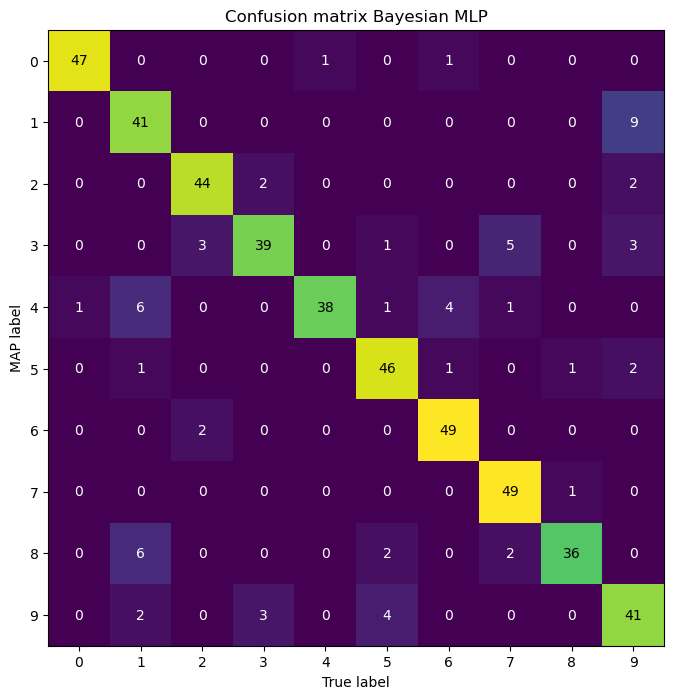

In [81]:
from sklearn.metrics import confusion_matrix

def compute_class_prob_vector(y_):
    return jnp.bincount(y_, length=num_classes) / 1000

#

class_probs = jax.vmap(compute_class_prob_vector, in_axes=1)(predictions['y'])
y_map = jnp.argmax(class_probs, axis=1)

conf_mat = confusion_matrix(y_test, y_map, labels=jnp.arange(num_classes))

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.imshow(conf_mat)
for i in range(num_classes):
    for j in range(num_classes):
        color = 'k' if i==j else 'w'
        text = ax.text(j, i, conf_mat[i, j], ha='center', va='center', color=color)
ax.set_xticks(jnp.arange(num_classes))
ax.set_yticks(jnp.arange(num_classes))
ax.set_xlabel('True label')
ax.set_ylabel('MAP label')
ax.set_title('Confusion matrix Bayesian MLP');

The MLP works well when we look at the MAP predictor, but it's more interesting to see the distribution of class probabilities for the images that aren't so clearly recognizable. For example, the image below is a 7, but also looks a bit like a 3, which the classifier also picks up:

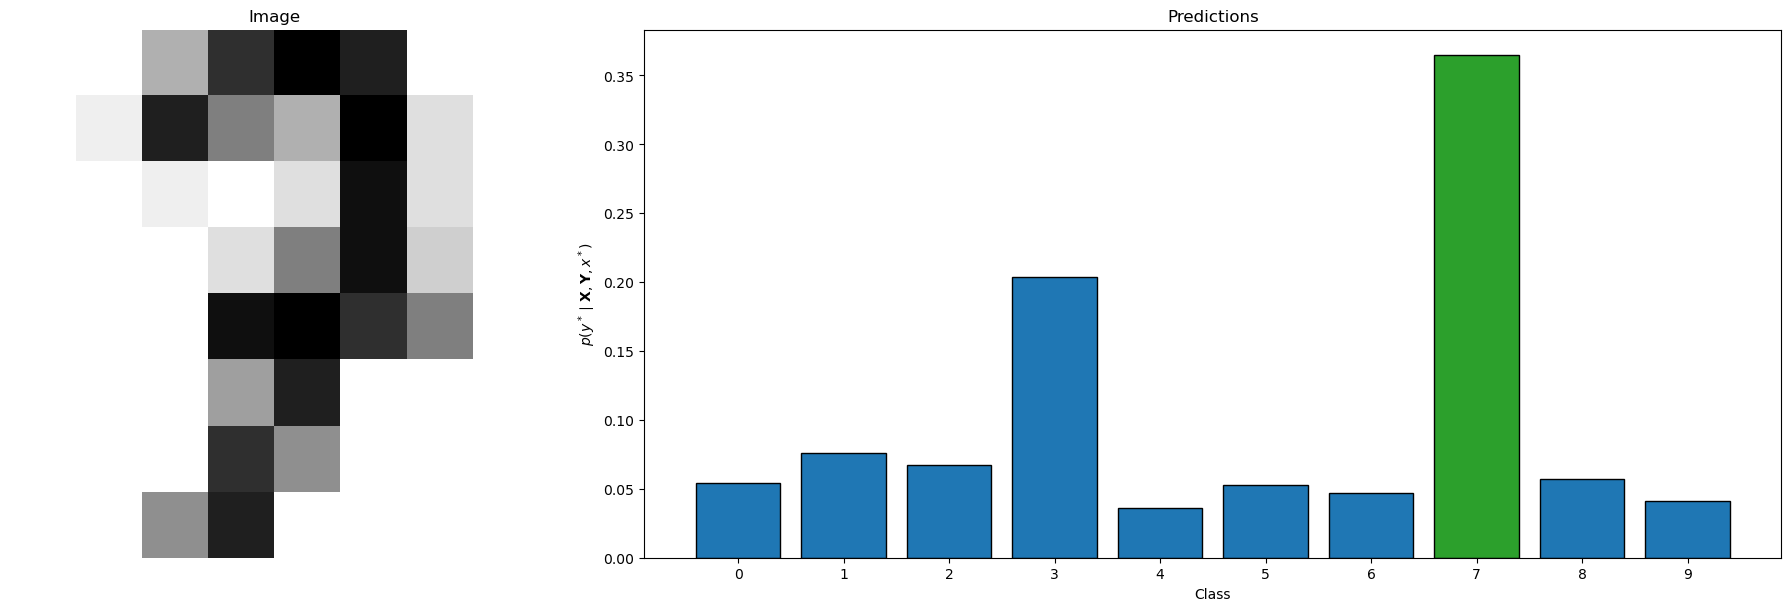

In [86]:
test_ix = 4

x_pred = X_test[test_ix, :]
img = x_pred.reshape((res, res))
label = y_test[test_ix]

y_pred = predictions['y'][:, test_ix]

class_probs = jnp.bincount(y_pred, length=num_classes) / 1000

fig, axes = plt.subplot_mosaic([['image', 'bar plot']], width_ratios=(1, 2), constrained_layout=True, figsize=(18, 6))
axes['image'].imshow(img, cmap='binary')
axes['image'].set_title(f'Image')
axes['image'].axis('off')

bars = axes['bar plot'].bar(jnp.arange(num_classes), class_probs, edgecolor='k')
bars[label].set_facecolor('tab:green')
axes['bar plot'].set_xticks(jnp.arange(num_classes))
axes['bar plot'].set_xlabel('Class')
axes['bar plot'].set_ylabel(r'$p(y^* \mid \mathbf{X}, \mathbf{Y}, x^*)$')
axes['bar plot'].set_title('Predictions');